In [ ]:
## BASICS
import numpy as np  # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import seaborn as sns
import itertools
import matplotlib.pyplot as plt
import math
from matplotlib.patches import Circle, Wedge, Polygon
from IPython.display import display, HTML

## DSP
! pip install control
! pip install audiolazy
! pip install PyDynamic
from IPython.display import Audio
from PyDynamic.identification.fit_filter import LSIIR
from scipy.io import wavfile
from scipy import signal, fftpack
import control
import cmath
import sympy

     |████████████████████████████████| 266kB 4.2MB/s 
  Created wheel for control: filename=control-0.8.4-py2.py3-none-any.whl size=276947 sha256=5dc303df1527c62d7b0289f81c6f87a8736cdc5746ea34d70126277a57c9b1df
  Stored in directory: /root/.cache/pip/wheels/3e/a4/9a/8b6ad43fcb2aba7debf8188b60a3def7aaa9a11582b7929ead
Successfully built control
     |████████████████████████████████| 122kB 4.4MB/s 
     |████████████████████████████████| 71kB 3.4MB/s 


/usr/local/lib/python3.6/dist-packages/PyDynamic/identification/fit_filter.py:29: DeprecationWarning: The module *identification* will be combined with the module *deconvolution* and renamed to *model_estimation* in the next major release 2.0.0. From version 1.4.1 on you should only use the new module *model_estimation* instead.
  DeprecationWarning,
/usr/local/lib/python3.6/dist-packages/PyDynamic/identification/fit_transfer.py:28: DeprecationWarning: The package *identification* will be combined with the package *deconvolution* and renamed to *model_estimation* in the next major release 2.0.0. From version 1.4.1 on you should only use the new package *model_estimation* instead.
  DeprecationWarning,
/usr/local/lib/python3.6/dist-packages/PyDynamic/uncertainty/interpolation.py:28: PendingDeprecationWarning: The module :mod:`PyDynamic.uncertainty.interpolation` will be renamed to :mod:`PyDynamic.uncertainty.interpolate` in the next major release 2.0.0. From version 1.4.3 on you should 

# **DUAL-TONE MULTI-FREQUENCY (DTMF)**

|Frequencies | 1209Hz |  1336 Hz | 1477 Hz | 1633Hz|
|:--:|:--:|:--:|:--:|:--:|
**697Hz** | 1 | 2 | 3 |A|
**770Hz** | 4 | 5 | 6 |B|
**852Hz** | 7 | 8 | 9 |C|
**941Hz** | * | 0 | # |D|




# **PART 1 🔁 - create 10-digit number** 5201500055
## CONFIGURATION
* $f_s = 8 kHz, \quad T = f_s^{-1}$
* Each number is represented by the signal $x[n]$ which is discrete $N$ samples signal.
* Between each number there will be a gap of $0.1$ sec while each $x_{i}[n]$ of the i-th digit will have a duration of $0.5$ sec. The total duration of 10-digit number will be $t = 10\cdot 0.5 + 8 \cdot 0.1 = 5.9sec$

## SIMULATE PHONE NUMBER
**"5"** :  $x_5[n] = cos(2\pi n \cdot 770) + cos(2\pi n \cdot 1336), \quad n = 0, 1, ... , N - 1 $ \\
**"2"** :  $x_5[n] = cos(2\pi n \cdot 697) + cos(2\pi n \cdot 1336)$ \\
...

In [ ]:
## CONFIGURATION & UTILITY FUNCTIONS
fs = 8_000
number = "5201500055"
DTFM = {"1" : (697, 1209), "2" : (697, 1336), "3" : (697, 1477),
        "4" : (770, 1209), "5" : (770, 1336), "6" : (770, 1477),
        "7" : (852, 1209), "8" : (852, 1336), "9" : (852, 1477),
        "0" : (941, 1336)}
DTFM_inv = {v : k for k, v in DTFM.items()}

m = 0.5 #length of each tone
s = 0.1 #space between tones
n = np.arange(0, m, 1/fs)
space = np.zeros(int(s * fs))

def calculate_fft(x):
  ## Calculate DFT (by using the FFT algorithm)
  N = 2000                        # number of DFT samples
  x = signal.resample(x, N)   
  f = fftpack.fftfreq(N) * (2*N)  # Natural frequencies
  X = 1/N * fftpack.fft(x)        # Fourier coefficients (divided by N) #
  return f, X

def plot_fft(X, f):
  # configuration
  colors = sns.color_palette('Reds',n_colors = len(Xs))
  fig, ax = plt.subplots(figsize = (16,10))
  for idx in range(10) :
    Xi = X[idx]
    markers, stems, _  = ax.stem(f, np.abs(Xi), label = r"Amplitude (DFT) $X_{}[k]$".format(idx))
    plt.setp(markers, 'markerfacecolor', colors[idx])
    for i in range(len(stems)):
      stems[i].set_linewidth(1)
      stems[i].set_marker(1)
      stems[i].set_color(colors[idx])
  ax.set_title(r"DFT Magnitude Spectrum $|X(k)|$ ", size = 16, style = 'italic')
  ax.set_xlabel('Frequency in Hertz [Hz]')
  ax.set_ylabel('Frequency Domain (Spectrum) Magnitude')
  ax.grid(True, color = 'gray', alpha = 0.5)
  ax.legend(fancybox = True)
  plt.show()

def split_dtmf(x, win = 240, th = 200):
  '''
  Args: x : the signal
        win: The window size, default is 240
        th: The threshold, default is 200
  Returns:
        tones: A list of tuples with start and stop indices of each tone
  '''
  tones = []
  w = np.reshape(x[:int(len(x)/win)*win], (-1, win))
  w_e = np.sum(w*w, axis = 1)
  L = len(w_e)

  idx = 0
  while idx < L:
    while idx < L and w_e[idx] < th:
      idx = idx + 1
    if idx >= L:
      break
    i = idx
    while i < L and w_e[i] > th:
      i = i + 1
    tones.append((idx * win, i * win))
    idx = i

  return tones

In [ ]:
## CONSTRUCT SIGNALS
def create_my_number(number):
  x, X = np.array([]), []
  for num in list(number):
    f1, f2 = DTFM[num]
    # step 1 [TIME DOMAIN] : [ 0.5 sec : samples, 0.1 sec : gap or samples/5]
    xi = np.cos(2*np.pi*f1*n) + np.cos(2*np.pi*f2*n)
    x = np.concatenate((x, xi, space))
    # step 2 [FREQUENCY DOMAIN] : Calculate 10 DFTs of the respective digits
    f, Xi   = calculate_fft(xi)
    X.append(Xi)

  # step 3 [FREQUENCY DOMAIN]: Plot the DTFTs
  # plot_fft(X, f)
  return x

x = create_my_number(number)

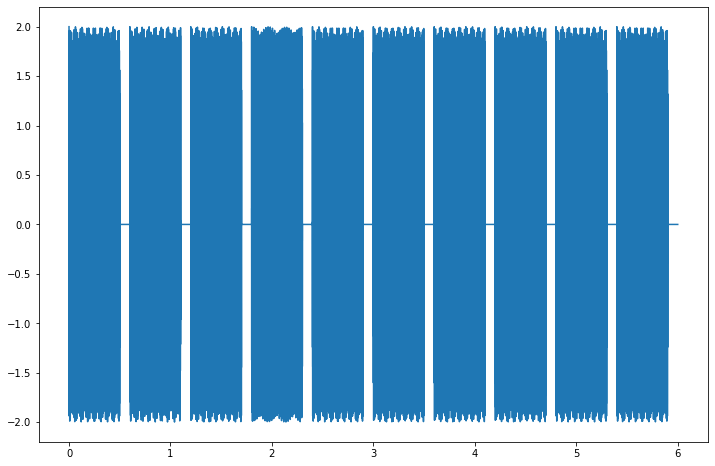

In [ ]:
## PLAY THE AUDIO
display(Audio(x, rate = fs))
fig, ax = plt.subplots(figsize = (12,8))
plt.plot(np.arange(0, len(x)/fs, 1/fs), x)


#### **NOTES 📌**
* Each digit , or "beep", consists of two simultaneous frequencies mixed together (added amplitudes). Standards specify 0.7% typical and 1.5% maximum tolerance. The higher of the two frequencies may have higher amplitude (be "louder") of 4 dB max. This shift is called a "twist". If the twist is equal to 3 dB, the higher frequency is 3 dB louder. If the lower frequency is louder, the twist is negative
* **CALCULATE DFT** : A large N makes the spacing smaller, providing higher resolution in the frequency domain but longer computation time.
* **FREQUENCIES** :The 10 digits DTFM cover 7 distinct frequencies. However our input number is "5201500055" does not include the digits [3,4,6,7,8,9], so we expect the DTF of the all digits will not exert a frequency content at the frequencies $f = 1477, 852$ Hz. Indeed,as we see the visualization of the DTF of all 10-digits cover CORRECTLY the rest 5 frequencies $f = 697,770,941,1209, 1336Hz$ 
* **AMPLITUDE** : 

# **PART 2 📶 - CONSTRUCT FIR filter**
##INPUT
We should create a FIR filter that filters out the following digits (and their respective frequencies)

| |$f_1$ | $f_2$ | 
|:-:|:-:|:-:|
**7** | 852 | 1209|
**8** | 852 | 1336|
**9** | 852 | 1477 | 
**0** | 941 | 1336| 

But the filter cannot cut off the frequencies $f_2$ alone because they also encode other digits that should be kept! So, the chosen FIR filter will be used for each $x_i[n]$ seperately taking into consideration both $f_1, f_2$ together for an effective filtering.

Note, that the signal $x$ includes the silences of $0.1$ sec. However for the analysis we must determine all the tones $x_i$ (where the tone starts, ends). The function `split_dtmf()` check the energy of segments of the signal, and if it is less than a determined threshold then we found a silence segment, and we move on the next tone after storing the range.

## OUTPUT
Moreover, our input number is $x = 5201500055$, we expect the output number to be $y = 521555$. We saw before that the input number has a frequency spectrum with 5 distinct frequency peaks. Now, after the elimination of the digit "0", we expect the elimination of the frequency $f = 941 Hz$ to be left off with 4 distinct frequency peaks

## FILTER DESIGN
* Since the minimum difference between any two pure sinusoidal frequencies is 73 Hz (697 and 770 Hz), the allowed band-width for band-pass filters can range to 25 Hz. 
* In order to maximize the discrimination of the DTMF sinusoids, the
selective bands of the FIR filters should be as narrow as
possible
* The way we will do it in this lab is to build a bandpass filter and detector for each of the eight DTMF frequencies. Thus, if the number ``8'' is pressed the outputs of the 853 Hz and 1336 Hz detectors should go high, while the outputs of the other detectors should remain low
* In our case we need a **bandstop filter**. We will make a simple implementation. So our input is the 5.9 sec signal (10-digit) $x$. The passband filter we will **stop** the frequency bands [800,100], so digits [7,8,9,*, 0, #] will be left with only **1** frequency, instead of the initial **2** that are necessary to recognize the digit. So, any decode function (part4) would fail at recognizing these digits !
  * $f_{lowcut} = 800Hz$
  * $f_{highcut} = 1000Hz$
  * $order = 5$, but we could use more for better precision (but with more computational effort)

* It would be perfect to also remove these high frequencies left (the second frequency) of these filtered digits! In our case only from the digit "0"



In [ ]:
#Plot frequency and phase response
from pylab import *
import scipy.signal as signal

def butter(fs, lowcut = 0.0, highcut = 0.0, kind = 'bandstop', order = 5):
    f_nyq = fs / 2
    low = lowcut / f_nyq
    high = highcut / f_nyq
    if kind == "low" : 
      b, a = signal.butter(order, low, btype = kind)
    elif kind == "high" : 
      b, a = signal.butter(order, high, btype = kind)
    else:
      b, a = signal.butter(order, [low, high], btype = kind)
    return b, a


def plot_time_domain(signals):
  x, y = signals
  n = np.arange(0, len(x)/fs, 1/fs)

  fig, ax = plt.subplots(figsize = (10,8))
  sns.set_style("darkgrid")
  ax.set_title(r"Output signal $y[n] = h_{FIR}[n] * x[n]$", size = 16, style = 'italic')
  ax.legend(fancybox = True)
  ax.set_xlabel('time (sec)', fontsize = 16)
  ax.set_ylabel('amplitude', fontsize = 16)
  ax.plot(n, x, 'r.-', linewidth = 1,  label = r"input signal $x[n]$" )
  ax.plot(n, y, 'b.-', linewidth = 1,  label = r"filtered signal $y[n]$" )
  ax.grid(True, color = 'gray', alpha=0.5)
  ax.legend(fancybox=True)
  plt.show()

def plot_freq_domain(signals, filter):

  # step 1 : split x, y into the dinstinct tones & calculate DFT X[k], Y[k]
  X, Y = [], []

  x, y = signals
  for idx in split_dtmf(x):
    xi = x[idx[0] : idx[1]]
    f, Xi = calculate_fft(xi)
    X.append(Xi)
  
  for idx in split_dtmf(y):
    yi = y[idx[0] : idx[1]]
    f, Yi = calculate_fft(yi)
    Y.append(Yi)
  # step 2 : retrieve bandstop filter H[k]
  w, h = filter

  # step 3 : visualize
  fig, ax = plt.subplots(figsize = (14,10))
  sns.set_style("darkgrid")
  ax.set_title(r"Output Spectrum  $Y[k] = H_{FIR}[k] \cdot X[k]$", size = 16, style = 'italic')
  ax.plot((fs * 0.5 / np.pi) * w, abs(h), label = "BandStop Filter $H[k]$".format(f))
  for idx in range(len(X)) :
    Xi = X[idx] 
    N = len(Xi)
    label = r"Amplitude (DFT) $X[k]$" if idx == 0 else "_nolegend_"
    ax.stem(f[ : N//2], np.abs(Xi[ : N//2 ]), linefmt = '-b',  markerfmt = 'bo', label = label)
  for idx in range(len(Y)): 
    Yi = Y[idx] 
    N = len(Yi)
    label = r"Amplitude (DFT) $Y[k]$" if idx == 0 else "_nolegend_"
    ax.stem(f[ : N//2], np.abs(Yi[ : N//2 ]), linefmt = '-r',  markerfmt = 'ro', label = label)

  ax.set_title(r"DFT Magnitude Spectrum $|X(k)|$ ", size = 16, style = 'italic')
  ax.set_xlabel('Frequency in Hertz [Hz]')
  ax.set_ylabel('Frequency Domain (Spectrum) Magnitude')
  ax.grid(True, color = 'gray', alpha = 0.5)
  ax.legend(fancybox = True)
  plt.show()



No handles with labels found to put in legend.


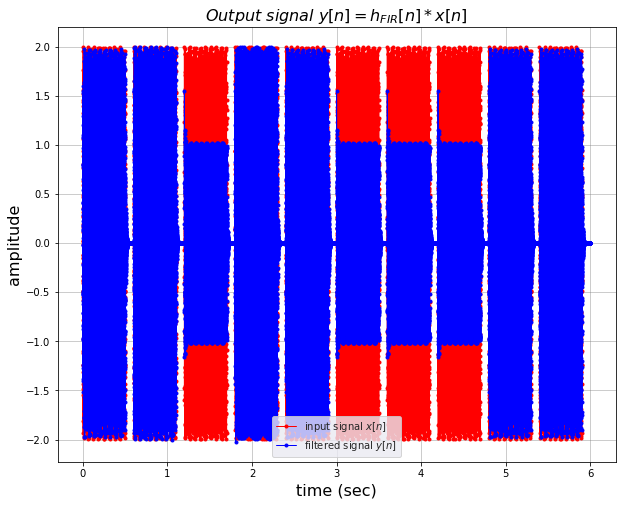

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:61: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:61: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:61: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning 

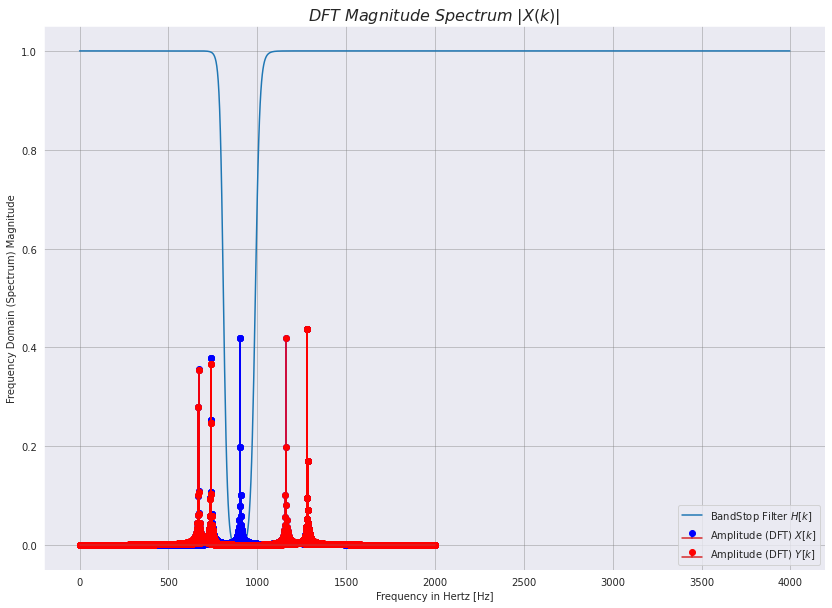

In [ ]:
def filter_my_number(x) : 
  ## step 1 : FIR filter design h[n]
  fs = 8000.0
  order = 5
  lowcut  = 800
  highcut = 1000
  b, a = butter(fs, lowcut, highcut, 'bandstop', order)
  w, h = signal.freqz(b, a, worN = 1000)

  ## step 2 : FIR filter application y[n] = x[n] * h[n] 
  y = signal.lfilter(b, a, x)

  display(Audio(x, rate = fs))
  display(Audio(y, rate = fs))

  ## step 3 : [TIME DOMAIN] PLOT the results 
  plot_time_domain(signals = [x, y])

  ## step 4 : [FREQUENCY DOMAIN] Plot the results
  plot_freq_domain(signals = [x, y], filter = [w,h])
  

filter_my_number(x)


#### **NOTES 📌**
* **TIME DOMAIN visualization** : We notice that the segments of the signal referring to the digit "0" are exhausted with amplitude 1, the rest have still amplitude 2. The filter has filtered out the one necessary frequency $f = 941Hz$ and teh respective cosine part of the segment. 
* **FREQUENCY DOMAIN visualization** : We can conclude that the filter worked properly since the $f = 941Hz$ is indeed left out from the signal $y$ after applying the **bandstop** filter ! 
* We could use another filter to filter out the remaining frequency of the digits [0,7,8,9], however that would lead to the application of the filter per segment which is computationally heavy. Instead, we simply apply 1 filter just once in the whole signal and this work fine since during the decoding the digit "0" would not be decoded ! 
* The **Butterworth and Chebyshev** polynomials are poor prototypes for FIR filters. However, as we will show next, some polynomials do work reasonably well.

# **PART 3 📶 - CONSTRUCT FIR filter to count "0"**
## FILTER DESIGN
* An effective way for determining a tone is create a bank of filters as shown below. In this figure, as an example, it shows a "0" signal entering the filter bank. Note that the bandpass filters (BPFs) associated with the 941 Hz and 1336 Hz tones provide the largest outputs.
  * **LOWPASS FILTER** : $f_{cutoff} = 941 + \frac{1204 - 941}{2} = 1075 Hz$, we use an $order = 30$, in order to reduce a lot the transition width that would affect the frequencies near the $f$. 
  * **HIGHPASS FILTER** : $f_{cutoff} = 1204 - \frac{1204 - 941}{2} = 1075 Hz$. Let $order = 30$
  * **BANPASS FILTERS** : Let $f$ be the frequency (central) of the filter , then $f_{lowcutoff} = f - 25Hz, f_{highcutoff} = f + 25Hz$ around the frequency. So, we can accomplish a narrow band with just an $order = 5$. This experimentation with different orders is crucical in order to reduce the computational cost!

## METHODOLOGY
1. We will split the signal into tones by calling again the function `split_dtmf()`
2. We will find the 2 required frequencies to recognize the digits. 
  * For the $f_{low}$ we will apply a **lowpass** filter to remove the high frequencies, and after that we will apply $4$ different **bandpass** filters to find which frequency is indeed high
  * For the $f_{low}$ we will apply a **highpass** filter to remove the high frequencies, and after that we will apply $3$ different **bandpass** filters to find which frequency is indeed high


<a href="https://ibb.co/T4F6Cpx"><img src="https://i.ibb.co/9bC6Mzk/1.png" alt="1" border="0"></a><br /><a target='_blank' href='https://imgbb.com/'></a><br />


In [ ]:
## UTILITY FUNCTIONS
def plot_filters(filters, lowhigh = False) : 
  fig, ax = plt.subplots(figsize = (12,8))
  plt.clf()
  if lowhigh : 
    plt.plot((fs * 0.5 / np.pi) * filters[0][2], abs(filters[0][3]), label = "Lowpass filter f = {}Hz".format(filters[0][4]))
    plt.plot((fs * 0.5 / np.pi) * filters[1][2], abs(filters[1][3]), label = "Highpass filter f = {}Hz".format(filters[0][4]))
  for f in filters[2:] : 
    plt.plot((fs * 0.5 / np.pi) * f[2], abs(f[3]), label = "BP Filter f = {}Hz".format(f[4]))
  plt.plot([0, 0.5 * fs], [np.sqrt(0.5), np.sqrt(0.5)], '--', label='sqrt(0.5)')
  plt.xlabel('Frequency (Hz)')
  plt.ylabel('Gain')
  plt.grid(True)
  plt.legend(loc = 'best')

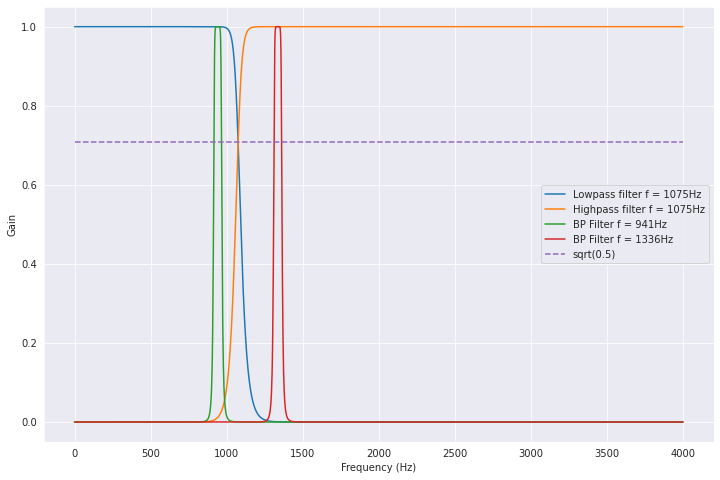

In [ ]:
## [2 LOWPASS + HIGHPASS FILTERS]
b, a = butter(fs, lowcut = 1075, kind = "low", order = 30)
w, h = signal.freqz(b, a, worN = 2000)
filter_lp = [b, a, w, h, 1075] 

b, a = butter(fs, highcut = 1075, kind = "high", order = 30)
w, h = signal.freqz(b, a, worN = 2000)
filter_hp = [b, a, w, h, 1075] 

## [7 BANDPASS  FILTERS ] (one for each frequency)
filters_bp = {697 : [] , 770 : [] , 852 : [] , 941 : [] ,
              1209 : [] , 1336 : [] , 1477 : [] }

for f, v in filters_bp.items():
  f_l  = f - 25
  f_h = f + 25
  b, a = butter(fs, lowcut = f_l , highcut = f_h, kind = "bandpass")
  w, h = signal.freqz(b, a, worN = 2000)
  filters_bp[f] = [b, a, w, h, f]

plot_filters([filter_lp, filter_hp, filters_bp[941], filters_bp[1336]], lowhigh = True)

The no. of zeros in the number - 5201500055 : 4


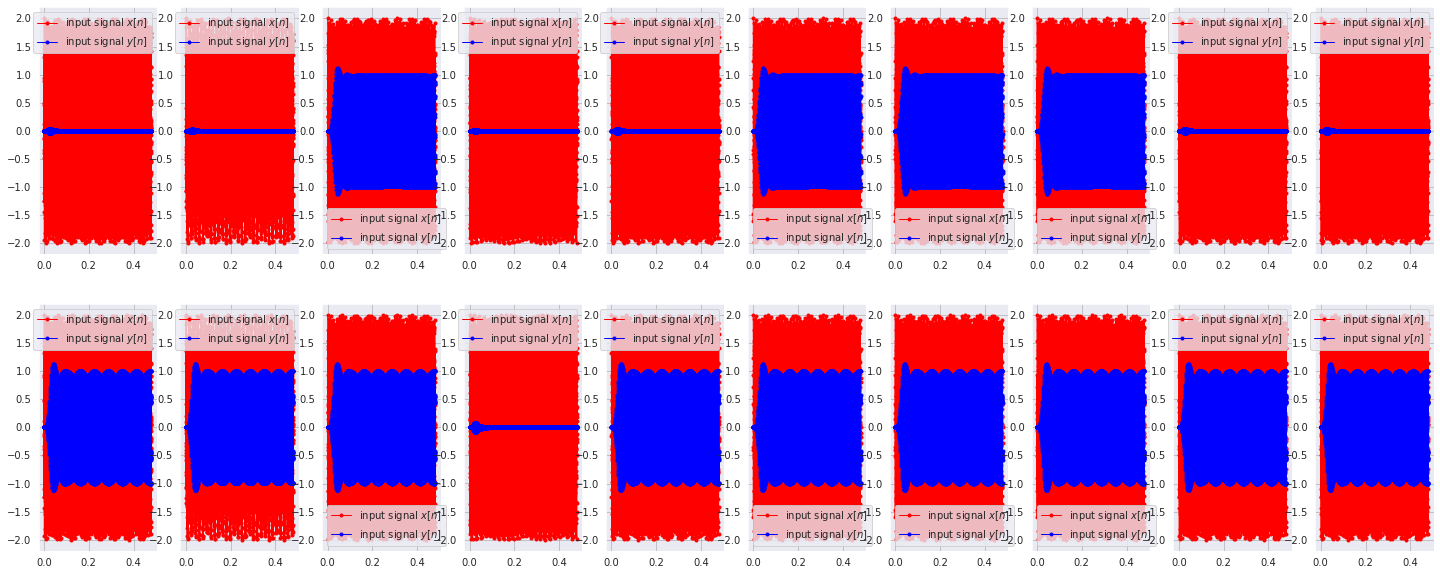

In [ ]:
def count_my_zeros(x) :
  fig, axs = plt.subplots(nrows = 2, ncols = 10, figsize = (25,10))
  sns.set_style("darkgrid")
  zeros = 0
  th = 0.3
  i = 0
  ## step 1 : split the signal into tones
  for idx in split_dtmf(x):
    xi = x[idx[0] : idx[1]]
    n = np.arange(0, len(xi)/fs, 1/fs)

    ## step 1.1 : check if f = 941 Hz is present in this tone
    b, a, _, _, _ = filter_lp
    yi = signal.lfilter(b, a, xi)
    b, a, _, _, _ = filters_bp[941]
    yi = signal.lfilter(b, a, yi)
    low = 1 if max(yi) > th else 0

    ## step 1.2 : visualize
    axs[0,i].plot(n, xi,'r.-', linewidth = 1,  label = r"input signal $x[n]$" )
    axs[0,i].plot(n, yi,'b.-', linewidth = 1,  label = r"input signal $y[n]$" )
    axs[0,i].legend(fancybox = True)
    axs[0,i].grid(True, color = 'gray', alpha=0.5)

    ## step 1.3 : check if f = 1336 Hz is present in this tone
    b, a, _, _, _ = filter_hp
    yi = signal.lfilter(b, a, xi)
    b, a, _, _, _ = filters_bp[1336]
    yi = signal.lfilter(b, a, yi)
    high = 1 if max(yi) > th else 0

    ## step 1.4 : visualize
    axs[1,i].plot(n, xi,'r.-', linewidth = 1,  label = r"input signal $x[n]$" )
    axs[1,i].plot(n, yi,'b.-', linewidth = 1,  label = r"input signal $y[n]$" )
    axs[1,i].legend(fancybox = True)
    axs[1,i].grid(True, color = 'gray', alpha=0.5)

    ## step 1.5 : find if digit = "0"
    if low and high : zeros += 1

    i += 1
  return zeros

zeros = count_my_zeros(x)
print("The no. of zeros in the number - 5201500055 : {}".format(zeros))




#### **NOTES 📌**
* We achieved the proper functionality by using 3 filters. In the future we could think of smarter ways (optimized) to reduce the numbers of filters needed to count our "0" in a signal 
* `split_dtmf()` still works fine with the specific window for this signal (the configuration is known), but we will see in the **part 4** that we should generalize the way we find the proper window since the test cases (new signals) would not necessary have the same configuration (e.g duration) like now.
* **WHY IT WORKS** : Fromt he visualization above we can see that for all "0" digits the filtered signals ($lowpass \rightarrow bandpass[941]$), ($highpass \rightarrow bandpass[1336]$) have **both** course non zero values. So we use 2 boolean variables to determine if both are non zero, in that case we increment the counter of the total "0" found in the signal

# **PART 4 📶 - DECODE DTMF signal**

## HOW TO SET THE WINDOW SIZE `split_dtmf()`
* We do not make a detection decision for every sample of the input signal Instead, we only make a decision every `win` samples. This makes it more likely that there will only be one decision made in the vicinity of the threshold
crossing. It also reduces computation time somewhat. We can choose a smaller number, but then we increase the risk the multiple-crossing problem. Alternatively, we can make it larger; however, it we make it too large, our detector may miss short tones or silences

## METHODOLOGY
1. The DTMF signal can have any amplitude, so it is recommended you normalize the signal (perhaps, after filtering out some noise) so the data falls within the range [-1, +1].
2. By “decode,” we simply
mean that we must decide which key was pressed to generate a particular DTMF tone. To do this, we determine which two bandpass filters have the largest output at each time when a DTMF tone was detected. 
3. Then, we effectively perform a dict look-up to see which key was pressed at these times (table `DTMF_inv`)
4. However, each DTMF tone will generally produce a sequence of identical numbers since it is “decoded” at many times during the duration of the DTMF tone. To translate this sequence of numbers into a sequence of key presses, we need a third step.

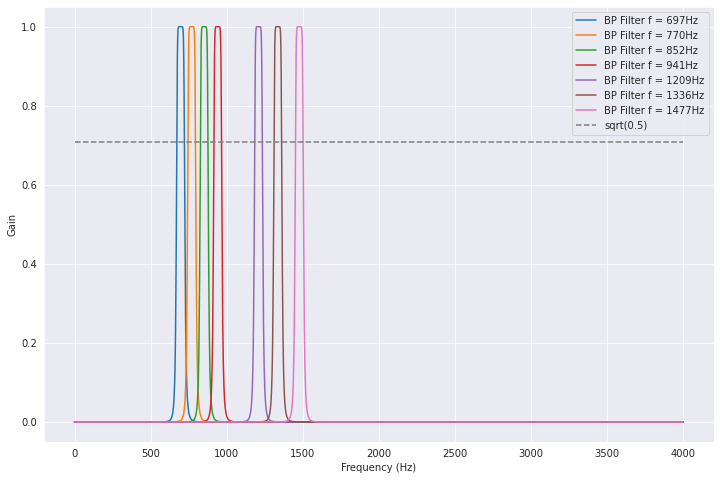

In [ ]:
## PLOT THE FILTERS USED
filters = [[], []] +  list(filters_bp.values())
plot_filters(filters, lowhigh = False)

In [ ]:
def decode_DTMF_signal(x):
  '''
  Args: x : the signal
  Returns : number
  '''
  number = ""
  th = 0.3
  ## step 0 : normalize the signal
  x = x / np.max(np.abs(x),axis = 0)
  ## step 1 : split the signal into tones
  for idx in split_dtmf(x, win = 300, th = 0.2):
    xi = x[idx[0] : idx[1]]
    n = np.arange(0, len(xi)/fs, 1/fs)

    ## step 1.2 : find low frequency
    f_low = 0
    b, a, _, _, _ = filter_lp
    yi = signal.lfilter(b, a, xi)
    for f, filter in filters_bp.items() : 
      if f > 1000 : continue
      b, a, _, _, _ = filter
      yi_bp = signal.lfilter(b, a, yi)

      if max(yi_bp) > th : 
        f_low = f
        break
    
    ## step 1.3 : find high frequency
    f_high = 0
    b, a, _, _, _ = filter_hp
    yi = signal.lfilter(b, a, xi)

    for f, filter in filters_bp.items() : 
      if f < 1000 : continue
      b, a, _, _, _ = filter
      yi_bp = signal.lfilter(b, a, yi)
      if max(yi_bp) > th : 
        f_high = f
        break

    ## step 1.4 : retrieve digit
    digit = DTFM_inv[(f_low ,f_high)]
    number += str(digit)
  return number


In [ ]:
## TEST CASE 1 : initial signal
num = decode_DTMF_signal(x)
print("The decoded number is = {}".format(num))

## TEST CASE 2 : 'number_to_unveil.wav'
fs, x2 = wavfile.read('number_to_unveil.wav')
num = decode_DTMF_signal(x2)
print("The decoded number is = {}".format(num))

## TEST CASE 3 : 'dtmfL1.wav'
fs, x3 = wavfile.read('dtmfL1.wav')
num = decode_DTMF_signal(x3)
print("The decoded number is = {}".format(num))

The decoded number is = 5201500055
The decoded number is = 6943120587
The decoded number is = 8548928


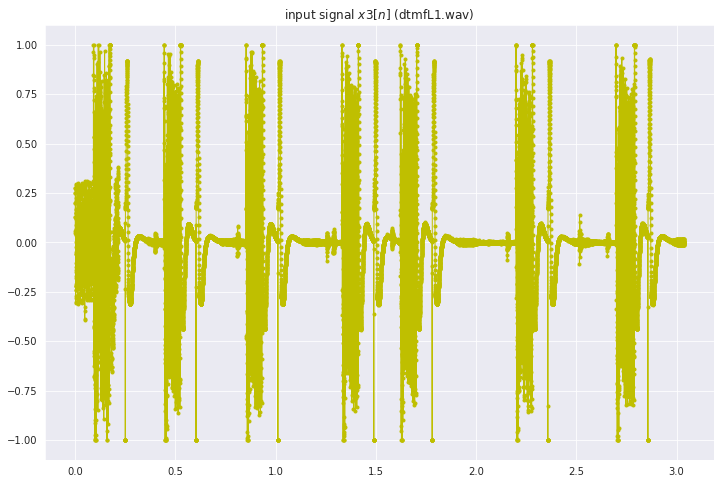

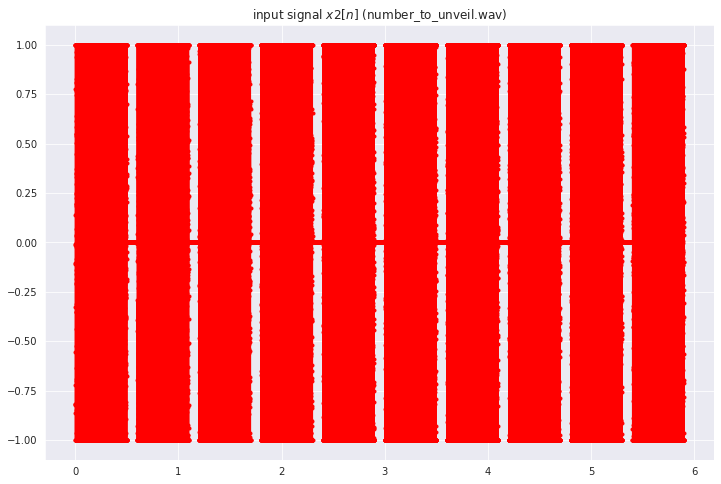

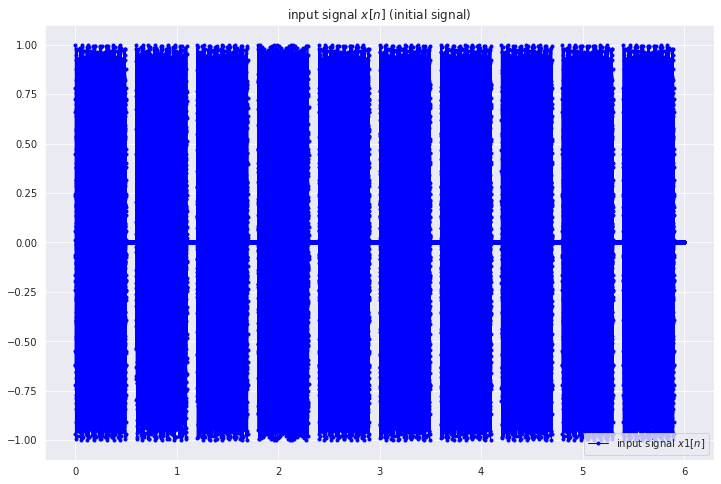

In [ ]:
## NORMALIZE, VISUALIZE
x_norm  = x /  np.max(np.abs(x),axis = 0)
x2_norm  = x2 /  np.max(np.abs(x2),axis = 0)
x3_norm  = x3 /  np.max(np.abs(x3),axis = 0)

display(Audio(x, rate = fs))
display(Audio(x2, rate = fs))
display(Audio(x3, rate = fs))

fig, ax = plt.subplots(figsize = (12,8))
n = np.arange(0, len(x3_norm)/fs, 1/fs)
ax.plot(n, x3_norm,'y.-', linewidth = 1,  label = r"input signal $x3[n]$" )
ax.set_title(r"input signal $x3[n]$ (dtmfL1.wav)")
fig, ax = plt.subplots(figsize = (12,8))
n = np.arange(0, len(x2_norm)/fs, 1/fs)
ax.plot(n, x2_norm,'r.-', linewidth = 1,  label = r"input signal $x2[n]$" )
ax.set_title(r"input signal $x2[n]$ (number_to_unveil.wav)")
fig, ax = plt.subplots(figsize = (12,8))
n = np.arange(0, len(x_norm)/fs, 1/fs)
ax.plot(n, x_norm,'b.-', linewidth = 1,  label = r"input signal $x1[n]$" )
ax.set_title(r"input signal $x[n]$ (initial signal)")
ax.legend()

#### **NOTES 📌**
* `split_dtmf()` : We see that a window of 300 is good enough to split properly the whole 3 signals (2 imported as .wav files) into tones. This can be proven by  playing the audio and count the number of tones heard.
* We were able to decode CORRECTLY all the tones from all the 3 signals ! The filters work fine. We were curious about the $Δf$ we would use for the passbands filters but a $Δf = 25Hz$ was suitable for every case! 